Modele simple utilisant les desingations et descriptions:
- une couche Embeddings
- une couche dense

In [1]:
import importlib


from RktnChallenge.RktnModel import ModelTrainer


from RktnChallenge.preprocessing.tokenizeString import tokenizeString
from RktnChallenge.preprocessing.filterStopWords import filterStopWords
from RktnChallenge.preprocessing.mergeFeatures import mergeFeatures
from RktnChallenge.preprocessing.mostOccur import mostOccur
from RktnChallenge.preprocessing.Dropper import Dropper
from RktnChallenge.preprocessing.TokenListToString import TokenListToString



from RktnChallenge.preprocessing.filterChar import filterChar
from RktnChallenge.preprocessing.lemmatize import lemmatize
from RktnChallenge.preprocessing.regularExprSub import regularExprSub

2023-09-08 13:11:45.571940: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-09-08 13:11:46.138412: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-08 13:11:47.644133: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-09-08 13:11:54.303668: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:02:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-09-08 1

In [2]:
RktnModel = ModelTrainer("data_tr.csv")

In [4]:
import pandas as pd
RktnModel = ModelTrainer("data_tr_lemm.csv")
RktnModel.data = RktnModel.data.drop_duplicates(subset=['designation', 'description'])
print(RktnModel.data.shape)

(83493, 21)


Vectorization des données

In [17]:
_X = RktnModel.data["merged_desi_desc"]

RktnModel.create_vectorizer(name="tokenizer", X = _X)

X_data = RktnModel.vectorizer_transform(_X)     


y = RktnModel.encodeLabel("prdtypecode")
label_size = RktnModel.getLabelSize()

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_data, y, test_size = 0.20, random_state = 42)


Definition d'un modele

In [7]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, GRUCell,RNN,GRU, Dense,Dropout,GlobalAveragePooling2D, LSTM, Flatten, Input
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.models import Model

_latent_dim = 600

vocab_size = RktnModel.vocab_size
print(vocab_size)
max_seq_length = RktnModel.max_seq_length
model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=_latent_dim, input_length=max_seq_length, mask_zero=True),  
    Flatten(),   
    #GRU(units=64, dropout=0.2, recurrent_dropout=0.2),
    Dense(units=label_size, activation="softmax")
])




optimizer = AdamW(weight_decay=0.01, learning_rate=0.001) 
model.compile(optimizer=optimizer,loss="sparse_categorical_crossentropy", metrics=['accuracy'])
model.summary()

142167
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 922, 600)          85300200  
                                                                 
 flatten (Flatten)           (None, 553200)            0         
                                                                 
 dense (Dense)               (None, 27)                14936427  
                                                                 
Total params: 100236627 (382.37 MB)
Trainable params: 100236627 (382.37 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


2023-09-08 11:40:45.988319: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:02:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-09-08 11:40:45.989008: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:02:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-09-08 11:40:45.989412: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:02:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-09-08 11:40:48.552283: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:02:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-09-08 11:40:48.552614: I tensorflow/compile

522/522 [==============================] - 1s 2ms/step
weighted F1 score: 0.8343823835936156


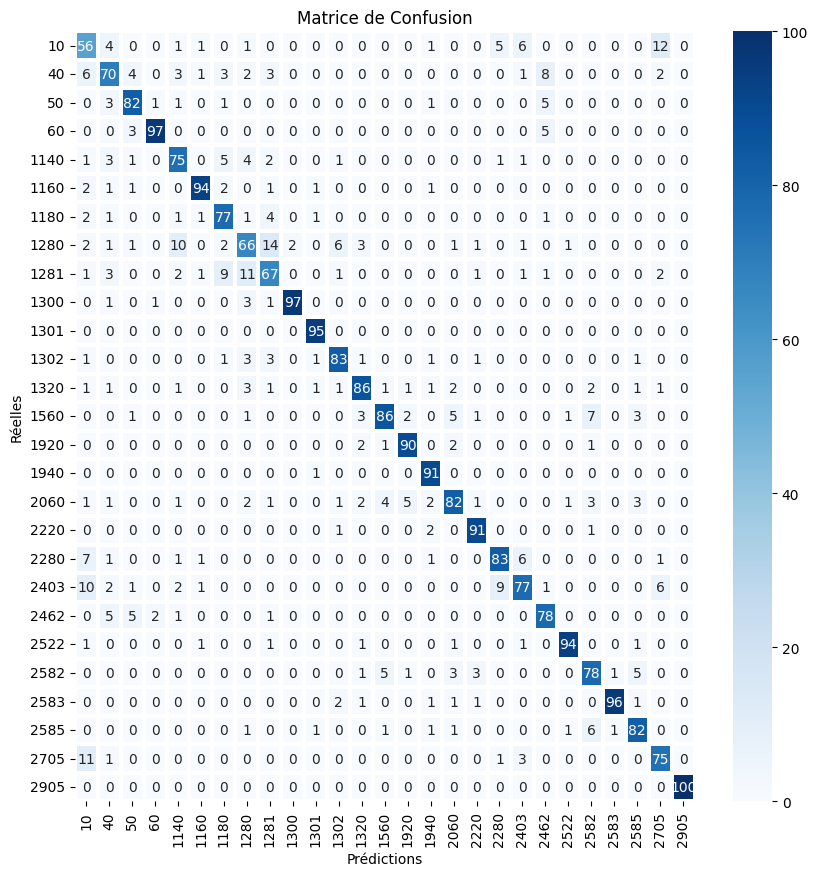

/home/pec/miniconda3/envs/tfGPU/lib/python3.9/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [8]:


y_pred_test = model.predict(X_test)
y_pred_id = y_pred_test.argmax(axis=-1)

RktnModel.evaluateTestResults(y_test,y_pred_id)


model.save("model_simple.h5")